# 引言
题材概念是主力炒作永恒的主题。市场的本质是资金驱动市，资金驱动的核心是主力。很多人都在复杂的理论、指标、图形和消息上折腾，把对股市的理解复杂化，理论的作用扩大化，没有从实践上去认识。题材是市场资金达成共识的工具，而题材的级别大小和想象力大小则决定了股票上涨的空间，级别越大，空间越大。市场的本质就是市场的主要矛盾，不外乎六点：经济、政策、情绪、资金、技术和外围环境。一旦出现赚钱效应，首先看的是那个整体板块在领涨，这个板块是什么概念，是不是当下的大热点？选股就是先看热点板块，龙头股与题材有关，题材代表了一个板块，不会是单打独斗，关注热点板块，在板块中选股非常重要。发现最大题材板块后，核心是找龙大。在整个板块中最先上涨，涨势最强的个股就一定要关注并分析。

In [69]:
import pandas as pd
import numpy as np
#可视化：matplotlib、seaborn、pyecharts
import matplotlib.pyplot as plt
import seaborn as sns
#正确显示中文和负号
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
#这里的pyecharts使用的是0.5.11版本
from pyecharts import Bar,HeatMap
#导入时间处理模块
from dateutil.parser import parse
from datetime import datetime,timedelta
#pandas赋值老提升警告
import warnings
warnings.filterwarnings('ignore')
#使用tushare pro获取数据，需要到官网注册获取相应的token
import tushare as ts 
token='输入你的token'
pro=ts.pro_api(token)

# 数据获取与探索性分析

## 同花顺概念和行业列表

In [70]:
index_list=pro.ths_index()
#查看数据前几行
index_list.head()

,ts_code,name,count,exchange,list_date,type
0,864006.TI,固态电池,3.0,A,None,N
1,864007.TI,太阳能,16.0,A,None,N
2,864008.TI,激光雷达,3.0,A,None,N
3,864009.TI,CAR-T,12.0,A,None,N
4,864010.TI,NFT,18.0,A,None,N


In [71]:
#数据保存本地
#index_list.to_csv('index_list.csv')
#读取本地数据
index_list=pd.read_csv('index_list.csv',index_col=0)

其中，ts_code：代码；name：名称；count：成分个数；exchange：交易所，包括A股、港股（H）和美股（US）；list_date：上市日期；type：指数类型N-板块指数，I-行业指数，S-同花顺特色指数。

In [72]:
def plot_bar(data,title,label=True,zoom=False):
    bar=Bar('')
    attr=list(data.index)
    v=list(data.values)
    bar.add(title,attr,v,is_label_show=label,
           is_splitline_show=False,
           is_datazoom_show=zoom)
    return bar

In [73]:
data=index_list.groupby('exchange')['name'].count()
title='同花顺概念和行业指数\nA股\港股\美股'
plot_bar(data,title)

下面主要分析A股上的同花顺概念和行业指数

In [74]:
A_index_list=index_list.query("exchange=='A'")
A_index_list=A_index_list.copy()
A_index_list['nums']=pd.to_numeric(A_index_list['count'])
#去掉缺失值
A_index_list.dropna(inplace=True)
A_index_list['nums'].describe()

count     909.000000
mean       53.379538
std       110.003875
min         1.000000
25%        12.000000
50%        26.000000
75%        52.000000
max      2242.000000
Name: nums, dtype: float64

概念或行业成分个股数量太多或太少，相当于涵盖面太宽泛或代表性不足，分析起来意义不大。

In [75]:
#删除代码重复项，筛掉概念成份个股数量低于12大于52（相当于取25%到75%分位数）
#保留type为N板块的指数
final_index_list=(A_index_list
                  .drop_duplicates(subset=['ts_code'], keep='first')
                 .query("12<nums<52")
                 .query("type=='N'"))
#去掉样本股或成份股指数
final_index_list=final_index_list[-final_index_list.name.apply(lambda s:s.endswith('样本股')or s.endswith('成份股'))]
final_index_list.sort_values('nums')

,ts_code,name,count,exchange,list_date,type,nums
453,885748.TI,可燃冰,13.0,A,20170623.0,N,13.0
490,885796.TI,送转填权,13.0,A,20180522.0,N,13.0
587,885923.TI,鸿蒙概念,13.0,A,20210603.0,N,13.0
575,885911.TI,社区团购,13.0,A,20201110.0,N,13.0
566,885902.TI,汽车拆解概念,13.0,A,20200805.0,N,13.0
...,...,...,...,...,...,...,...
482,885786.TI,富士康概念,50.0,A,20180306.0,N,50.0
420,885657.TI,供应链金融,50.0,A,20150812.0,N,50.0
578,885914.TI,煤炭概念,51.0,A,20201221.0,N,51.0
504,885818.TI,工业大麻,51.0,A,20190307.0,N,51.0


In [76]:
data=(final_index_list.sort_values('nums',ascending=False)
      .set_index('name')['nums'])
title='同花顺概念和行业指数成分股个数'
plot_bar(data,title,False,True)

## 获取概念行业指数行情
通过日期循环获取某时间段所有概念行业指数行情数据

In [77]:
#获取股票交易日历
def get_cals():
    #获取交易日历
    cals=pro.trade_cal(exchange='')
    cals=cals[cals.is_open==1].cal_date.values
    return cals
    
#获取某段时间内的交易日期（如200个交易日）
def get_trade_date(n):
    #获取当天日期时间
    d0=datetime.now()
    if d0.hour>20:
        d=d0.strftime('%Y%m%d')
    else:
        d=(d0-timedelta(1)).strftime('%Y%m%d')
    while d not in get_cals():
        d1=parse(d)
        d=(d1-timedelta(1)).strftime('%Y%m%d')
    #当前交易日在交易日历的索引
    n1=np.where(get_cals()==d)[0][0]
    #起始日期
    n0=n1-n+1
    return n0,n1
#获取某段时间内的概念指数行情数据

def get_index_data(n=200):
    n0,n1=get_trade_date(n)
    date1=get_cals()[n1]
    #获取起始日期至结束日期数据
    df=pro.ths_daily(trade_date=date1)
    for date in get_cals()[n0:n1]:
        temp=pro.ths_daily(trade_date=date)
        df=pd.concat([df,temp])
    return df

In [78]:
#通过tushare在线获取数据
all_data=get_index_data(n=200)
#数据保存本地
#all_data.to_csv('all_data.csv')
#通过本地导入数据
#all_data=pd.read_csv('all_data.csv',index_col=0)
all_data.head()

,ts_code,trade_date,close,open,high,low,pre_close,avg_price,change,pct_change,vol,turnover_rate
0,875069.TI,20220209,1668.140,1665.442,1681.772,1662.915,1665.442,8.4485,2.698,0.1620,485934.47,0.060658
1,885372.TI,20220209,1709.148,1680.596,1710.386,1675.273,1697.067,4.4973,12.081,0.7119,18160722.00,0.548379
2,881135.TI,20220209,1810.105,1804.856,1811.802,1798.120,1806.216,6.5441,3.889,0.2153,3083571.20,1.359293
3,881146.TI,20220209,1229.375,1222.393,1229.787,1216.593,1228.889,9.9978,0.486,0.0395,2032349.50,0.946237
4,885457.TI,20220209,2003.797,1951.841,2004.447,1948.636,1950.191,7.9046,53.606,2.7488,19447410.00,2.833457


In [79]:
#删除重复缺失值、将代码使用概念中文名代替
final_data=(all_data.sort_values(['ts_code','trade_date'])
            .drop_duplicates()
            .set_index(['trade_date','ts_code'])['close'].unstack()
            .dropna(axis=1)
            .rename(columns=dict(index_list[['ts_code','name']].values)))
final_data.tail()

ts_code,种植业与林业,养殖业,农产品加工,农业服务,煤炭开采加工,油气开采及服务,化学原料,化学制品,化工合成材料,钢铁,...,社区团购,有机硅概念,医美概念,煤炭概念,物业管理,同花顺漂亮100,新冠检测,快手概念,碳中和,光伏建筑一体化
trade_date,,,,,,,,,,,,,,,,,,,,,
20220127,2967.612,2522.808,3496.524,7922.890,1798.733,965.906,2893.163,5372.023,4164.727,1532.698,...,760.481,1469.203,1190.966,1477.677,996.091,881.572,1000.254,1052.957,1384.537,1398.814
20220128,3048.355,2573.747,3588.851,8092.303,1752.031,977.124,2912.758,5435.048,4224.453,1518.965,...,779.415,1478.922,1208.005,1449.700,1004.643,871.505,1007.796,1072.418,1400.474,1412.441
20220207,3105.105,2591.081,3621.694,8294.714,1825.078,1040.556,2999.568,5542.589,4279.754,1586.121,...,787.911,1531.024,1213.495,1508.211,1026.990,882.699,1013.469,1076.940,1432.551,1448.319
20220208,3170.406,2629.571,3694.027,8449.976,1919.840,1063.740,3066.299,5608.485,4333.012,1632.544,...,804.487,1540.895,1232.394,1578.789,1049.399,874.576,1024.262,1106.896,1459.718,1464.319
20220209,3236.999,2712.350,3776.176,8528.528,1920.268,1069.786,3097.891,5683.307,4390.550,1636.928,...,805.968,1557.519,1250.357,1586.341,1052.436,882.029,1038.638,1141.221,1477.938,1474.145


# 热点板块与个股监测分析

## 计算板块指数收益率

In [80]:
def date_ret(data,w_list=[1,5,20,60,120]):
    df=pd.DataFrame()
    for w in w_list:
        df[str(w)+'日收益率%']=(((data/data.shift(w)-1)*100)
                            .round(2)
                            .iloc[w:]
                            .fillna(0)
                            .T
                            .iloc[:,-1])
    return df

In [81]:
date_ret(final_data).sort_values('120日收益率%',ascending=False)

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
ts_code,,,,,
钾肥,1.65,-0.06,-7.07,9.40,64.69
微信小程序,5.76,4.96,15.02,43.77,49.48
养鸡,4.62,6.99,-5.49,15.30,43.63
酒店,2.52,2.39,9.92,23.48,42.83
数字货币,9.04,5.78,9.56,33.90,38.63
...,...,...,...,...,...
医疗研发外包,0.43,-4.07,-15.26,-21.41,-24.89
半导体设备,0.72,-7.84,-12.41,-26.27,-26.26
疫苗,1.65,1.01,-8.79,-4.15,-29.19


120日涨幅居前板块指数

In [82]:
date_ret(final_data).sort_values('120日收益率%',ascending=False)[:10]

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
ts_code,,,,,
钾肥,1.65,-0.06,-7.07,9.40,64.69
微信小程序,5.76,4.96,15.02,43.77,49.48
养鸡,4.62,6.99,-5.49,15.30,43.63
酒店,2.52,2.39,9.92,23.48,42.83
数字货币,9.04,5.78,9.56,33.90,38.63
机场,1.07,5.99,8.08,10.28,36.07
酒店及餐饮,1.77,3.77,6.24,21.96,34.47
互联网彩票,2.88,0.74,-4.51,16.51,34.06
风电设备,-0.05,3.63,-0.81,-13.57,33.86


120日跌幅最多的前五个板块指数

In [83]:
date_ret(final_data).sort_values('120日收益率%',ascending=True)[:5]

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
ts_code,,,,,
医疗美容,1.43,-0.20,-16.76,-24.00,-36.37
集成电路制造,1.27,0.89,-5.87,-12.92,-31.26
疫苗,1.65,1.01,-8.79,-4.15,-29.19
半导体设备,0.72,-7.84,-12.41,-26.27,-26.26
医疗研发外包,0.43,-4.07,-15.26,-21.41,-24.89


## 概念板块指数周期涨跌幅可视化

In [84]:
#使用pyecharts0.5.11版本可视化
def out_chart(w=120):
    col=str(w)+'日收益率%'
    ddd=date_ret(final_data).sort_values(col,ascending=False)[col]
    x=list(ddd.index)
    y=list(ddd.values)
    bar=Bar(f"同花顺概念指数{w}日收益率(%)",title_text_size=15,title_pos='center')
    bar.add("", x,y,is_label_show=False, is_datazoom_show=True)
    return bar

In [85]:
#最近一个交易日
#图形为html动态交互式，可通过拖曳查看所有概念指数的详细涨跌幅
out_chart(1)

In [86]:
#近5个交易日
out_chart(5)

In [87]:
#近20个交易日
#out_chart(20)

In [88]:
#近120个交易日
out_chart(120)

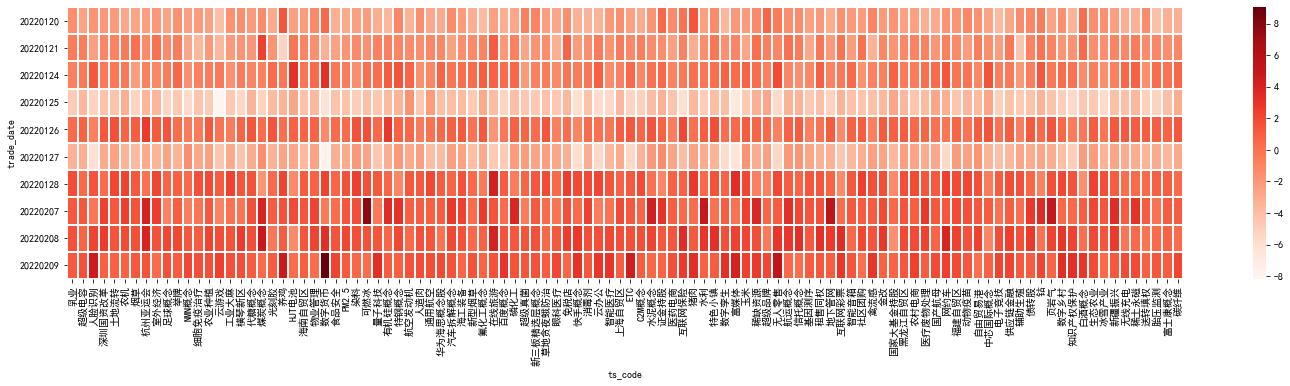

In [89]:
#由于同花顺指数行情数据获取不到下面概念，需剔除
xx=['华为汽车', '盐湖提锂', '鸿蒙概念', '共同富裕示范区', 'MCU芯片', '牙科医疗', 
    'CRO概念', '钠离子电池', '工业母机', '北交所概念', 'NFT概念', '抽水蓄能', 
    '换电概念', '海峡两岸', 'WiFi 6', '智能制造', 'EDR概念', '动力电池回收', 
    '汽车芯片', '传感器', '柔性直流输电', '虚拟数字人', '预制菜', '幽门螺杆菌概念']
sss=final_data[set(final_index_list.name.values)-set(xx)]
import seaborn as sns
pt = ((sss/sss.shift(1)-1)*100).round(2)[-10:]
plt.figure(figsize=(25,5))
sns.heatmap(pt, linewidths = 0.05,cmap='Reds');

## 热点板块成分股

In [90]:
#注意，写作本文是交易日期为20220209,即默认end='20220209'.
def get_stock_price(code,start='20200101'):
    df=ts.pro_bar(ts_code=code, start_date=start,adj='hfq')
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    return df.close
def all_stock_price(name):
    #name为同花顺概念行业中文名称
    dd=pro.ths_member(ts_code=dict(index_list[['name','ts_code']].values)[name])
    df0=pd.DataFrame()
    for code,name in dict(dd[['code','name']].values).items():
        df0[name]=get_stock_price(code)
    df1=df0.fillna(method='ffill')
    return df1
def stock_rets_rank(name,p=120):
    data=all_stock_price(name)
    #p为period，即时间窗口
    col=str(p)+'日收益率%'
    rank_ret=date_ret(data).sort_values(col,ascending=False)
    return rank_ret

In [91]:
stock_rets_rank('钾肥')

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
盐湖股份,1.61,1.00,-9.24,10.89,242.19
藏格矿业,3.78,3.14,-7.92,16.78,9.63
东方铁塔,-0.96,4.50,-0.11,18.49,7.27
亚钾国际,2.28,-8.70,-17.61,16.32,-11.33
三孚股份,1.56,-0.44,-4.10,-21.59,-38.74


In [92]:
stock_rets_rank('数字货币')

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
翠微股份,10.00,38.15,172.95,313.82,314.46
雄帝科技,20.00,31.60,112.49,146.75,171.15
恒宝股份,10.00,35.53,65.89,89.78,118.38
新开普,12.86,10.82,10.47,81.24,113.40
证通电子,9.98,1.64,57.74,93.76,96.55
神思电子,19.99,14.08,24.27,105.76,70.58
四川成渝,1.19,12.58,-6.76,51.34,69.44
京北方,10.01,5.20,21.20,53.93,68.44
新国都,17.00,15.74,11.39,76.69,67.74
海联金汇,10.05,6.27,19.15,48.63,59.89


In [93]:
stock_rets_rank('数字货币',p=1)[:20]

,1日收益率%,5日收益率%,20日收益率%,60日收益率%,120日收益率%
天喻信息,20.03,20.76,16.85,26.03,20.67
雄帝科技,20.00,31.60,112.49,146.75,171.15
创识科技,20.00,13.46,-7.30,21.82,24.34
神思电子,19.99,14.08,24.27,105.76,70.58
新国都,17.00,15.74,11.39,76.69,67.74
天阳科技,15.99,10.99,7.09,25.06,16.03
新开普,12.86,10.82,10.47,81.24,113.40
四方精创,11.38,-0.33,2.90,25.37,33.44
正元智慧,10.50,-11.36,-2.03,22.03,30.77
拉卡拉,10.50,10.79,1.60,21.91,22.86


热力图监测热点板块个股

In [94]:
def stock_heat(name='数字货币'):
    #name为板块指数名称，如数字货币
    #具体指数名称可通过index_list获取
    sss=all_stock_price(name)
    yy = ((sss/sss.shift(1)-1)*100).round(2)[-10:]
    yy.index=yy.index.strftime('%Y%m%d')
    y_axis = list(yy.index)
    x_axis = list(yy.columns)
    data = [[i, j, yy.loc[j,i]] for i in x_axis for j in y_axis]
    heatmap = HeatMap()
    heatmap.add(name+
    "板块个股涨跌",
    x_axis,
    y_axis,
    data,
    visual_range=[-20,20],   
    is_visualmap=True,
    visual_text_color="#000",
    visual_orient="horizontal",
    is_label_show=True,
    is_datazoom_show=True
    )
    return heatmap


In [95]:
stock_heat('数字货币')